In [1]:
from skimage.color import rgb2gray, rgb2lab, deltaE_cie76
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from sklearn.cluster import KMeans
from collections import Counter

# Kmeans cluster

This part will do the Kmean cluster to get which color is most dominant in the picture

(960, 1296, 3)


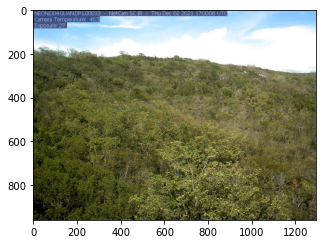

In [35]:
def readimg():
    """
        This function will read and show the image and also return it
    """
    image = plt.imread('../data_raw/GUAN/NEON.D04.GUAN.DP1.00033.jpg')/255
    print(image.shape)
    plt.imshow(image)
    return image
pic = readimg()

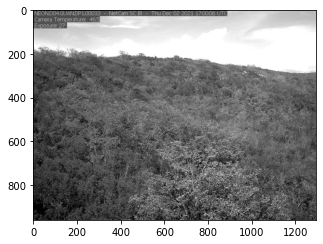

In [36]:
#convert the image to gray

gray = rgb2gray(pic)
plt.imshow(gray, cmap='gray')

In [37]:
gray.shape

(960, 1296)

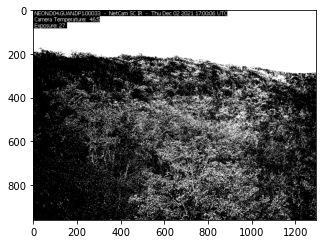

In [38]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
gray_mean = gray_r.mean()
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_mean:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

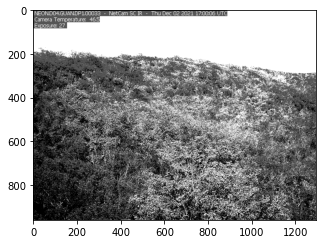

In [39]:
gray = rgb2gray(pic)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_mean:
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

In [40]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(1244160, 3)

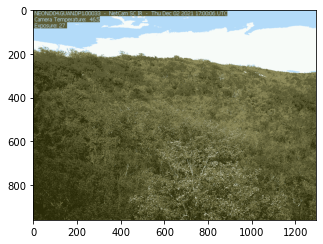

In [41]:
#perform the K mean with 5 clusters

kmeans = KMeans(n_clusters=5, random_state=0)
fit_model = kmeans.fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

In [42]:
cluster_pic[400][500]

array([0.3669044 , 0.36751836, 0.21466905])

# pie chart analyze image color

In [43]:
#Color identification - RGB to Hex Conversion
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

[array([0.3669044 , 0.36751836, 0.21466905]),
 array([0.70511348, 0.86166457, 0.97685524]),
 array([0.5734231 , 0.56085532, 0.36803681]),
 array([0.16746407, 0.17175823, 0.03467667]),
 array([0.96918968, 0.98501821, 0.97643357])]

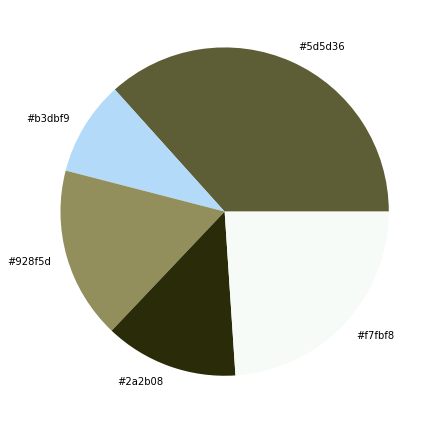

In [44]:
def countLabels(labels):
    """
    This function will perform the K mean and display it into to the pie chart
    
    params:
        labels: the list of labels available in the image
    """
    counts = Counter(labels)
    center_colors = kmeans.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    plt.figure(figsize = (8, 6))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    return rgb_colors
    
countLabels(fit_model.labels_)

# Making bigger window to check if it still works

In [45]:
from PIL import Image

In [46]:
old_image = Image.open("../data_raw/GUAN/NEON.D04.GUAN.DP1.00033.jpg").convert('RGB')
# im1 = old_image.split()
# im1[0].show()
# im1[1].show()
# im1[2].show()

In [47]:
def downsize_img(image):
    """
        downsize_img will traverse the pixel of the image and calculate the average
        value of a block in order to put it in the image
        
        image: an numpy array of m * n image of rgb value, dimension is m*n*3
        block_h: an integer that specifies how many pixel you want a block height to be
        block_w: an integer that specifies how many pixel you want a block width to be
    """
    im_h, im_w = image.shape[:2]
    block_h, block_w = 5, 5
    new_img = np.zeros((im_h//block_h, im_w//block_w, 3))
    for row in np.arange(im_h-block_h+1, step=block_h):
        for col in np.arange(im_w-block_w+1, step=block_w):
            new_img[row//block_h, col//block_w] = np.mean(image[row: row+block_h, col: col+block_w, :], axis = (0,1))
    return new_img

In [48]:
#convert old image into numpy array in order to downsize it
old_img = np.asarray(old_image)
# downsize the old image into new image
new_img = downsize_img(old_img)

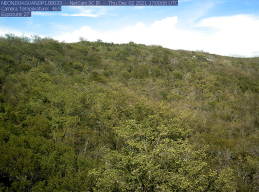

In [49]:
# convert the new image from numpy array back to RGB
Image.fromarray((new_img*1).astype(np.uint8)).convert('RGB')

In [50]:
def calculate_green_density(image, show_img = False):
    """
        calculate_green_density will calculate the density of the
        different shades of green appear in the image. THis function
        will also produce a new image that contains all the shades of
        green in the image for checking. 
        
        image, which is the numpy array representing the RGB image
        show_img is the boolean if we want to show the image with green mask
    """
    h, w = image.shape[:2]

    hsv = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (36, 25, 25), (170, 255,255))
    
    green = np.zeros_like(image, np.uint8)
    imask = mask > 0
    green[imask] = image[imask]
    
    ####display image
    if show_img:
        plt.imshow(green)
        plt.show()
    
    return np.count_nonzero(mask)/(h*w)

In [51]:
calculate_green_density(old_img)

0.7129107188786008

In [52]:
#compare the size of original image and new image dimensions
old_img.shape
new_img.shape

(192, 259, 3)

In [53]:
#calculate green density of new image
calculate_green_density(new_img)

0.7510456885456885

# Apply Kmean to segments (Not working)

In [54]:
def split_image(image, block_h = 2, block_w = 2):
    """
        split_image will split the image to different block with
        specified height and width
        
        image: an numpy array of m * n image of rgb value, dimension is m*n*3
        block_h: an integer that specifies how many pixel you want a block height to be
        block_w: an integer that specifies how many pixel you want a block width to be
    """
    im_h, im_w = image.shape[:2]
    new_img = np.zeros((im_h//block_h, im_w//block_w, block_h, block_w, 3))
    for row in np.arange(im_h-block_h+1, step = block_h):
        for col in np.arange(im_w-block_w+1, step = block_w):
            new_img[row//block_h, col//block_w] = image[row: row+block_h, col: col+block_w, :]
    return new_img
    

In [55]:
def get_kMean(pic):
    pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
    kmeans = KMeans(n_clusters=5, random_state=0)
    fit_model = kmeans.fit(pic_n)
#     pic2show = kmeans.cluster_centers_[kmeans.labels_]
#     print(pic2show.shape)
#     cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
#     plt.imshow(cluster_pic)
    return (fit_model, kmeans)

In [56]:
def countLabels2(labels, kmeans):
    counts = Counter(labels)
    center_colors = kmeans.cluster_centers_
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    plt.figure(figsize = (8, 6))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    return rgb_colors

In [57]:
partitioned = split_image(old_img, 150, 150)

In [58]:
# def apply_kMean_to_split(splitted):
#     h, w = splitted.shape[:2]
#     models = []
#     for row in np.arange(h):
#         for col in np.arange(w):
#             image = Image.fromarray((splitted[row, col]*1).astype(np.uint8)).convert('RGB')
# #             image.show()

#             vector_img = np.array(image)
# #             img = splitted[row, col]
#             kMeanModel, kmeans = get_kMean(vector_img)
# #             countLabels(kMeanModel.labels_)
# #             print(vector_img.shape)
#             models.append((kMeanModel, kmeans))
#     return models
# models = apply_kMean_to_split(partitioned)

In [59]:
countLabels2(models[1][0].labels_, models[1][1])

NameError: name 'models' is not defined

# Find All Color in image

In [60]:
def find_all_color(image):
    """
        find_all_color(image) will find all the color in image
        @param: image is the image opened as type Image
        @return: a dictionary of key RGB tuple and value count. e.g {(100,20,10):5}
    """
    colorCount = {}
    for pixel in image.getdata():
        colorCount[pixel] = colorCount.get(pixel, 0)+1
    return colorCount

In [61]:
def top_n_color_img(image, n):
    import heapq
    top = []
    allColor = find_all_color(image)
#     print(allColor)
    for color, count in allColor.items():
        heapq.heappush(top, (count, color))
        if len(top) > n:
            heapq.heappop(top)
    return dict(top)


In [62]:
lastYearImg = [
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_01_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_02_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_03_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_04_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_05_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_06_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_07_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_08_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_09_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_10_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_11_01.jpg', 
                '../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_12_01.jpg',
              ]

In [63]:
def color_sep_KMean(image, n):
    """
    This function will separate the images into color into specified K-mean
    
    params:
        image is the image that we want to separate into K mean
        n is the K value of K mean
    """
    img = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    kmeans=KMeans(n_clusters=n)
    s=kmeans.fit(img)
    labels=list(kmeans.labels_)
    centroid=kmeans.cluster_centers_
#     print(centroid*255)
#     percent=[]
#     for i in range(len(centroid)):
#         j=labels.count(i)
#         j=j/(len(labels))
#         percent.append(j)
#     plt.pie(percent,colors=np.array(centroid),labels=percent)
#     plt.show()
    percent = {}
    for i in range(len(centroid)):
        color = centroid[i]
        colorCount = labels.count(i)
        colorPercent = colorCount/len(labels)
        percent[RGB2HEX(color)] = colorPercent
    return percent

In [64]:
color_sep_KMean(plt.imread('../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_11_01.jpg')/255, 8)

{'#5d4a29': 0.18148809523809523,
 '#9d8c79': 0.1392857142857143,
 '#f6f6f7': 0.05136904761904762,
 '#a77843': 0.14547619047619048,
 '#412c10': 0.09833333333333333,
 '#855c2d': 0.19172619047619047,
 '#6a6f89': 0.03738095238095238,
 '#787057': 0.15494047619047618}

In [65]:
def plot_percentage_over_time(img_names):
    """
    This function will perform KMean cluster on the images in the array
    and print out the top K color of a specified month in the year
    
    param: img_names is the array that contain the name of the images
    """
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    colorsPercent = {}
    for i, name in enumerate(img_names):
        img = plt.imread(name)/255
        img_arr = np.asarray(img)*255
        curPercent = color_sep_KMean(img, 8)
        for color in curPercent:
            if color not in colorsPercent:
                colorsPercent[color] = [0]*(i)
            colorsPercent[color].append(curPercent[color])
        for color in colorsPercent:
            while len(colorsPercent[color]) < i+1:
                colorsPercent[color].append(0)
    count = range(1,len(img_names)+1)
    print(len(colorsPercent))
    fig, ax = plt.subplots()
    ax.stackplot(count, colorsPercent.values(), colors=colorsPercent.keys())
    plt.show()
    

91


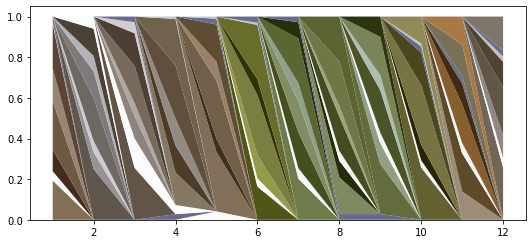

In [66]:
plot_percentage_over_time(lastYearImg)

# Histogram of the color

In [67]:
def rgb_density_histogram(image): 
    img = plt.imread(image)
    plt.show()

    color = ('b','g','r')
    for channel,col in enumerate(color):
        histr = cv2.calcHist([img],[channel],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.title('Histogram for color scale picture')
    plt.show()

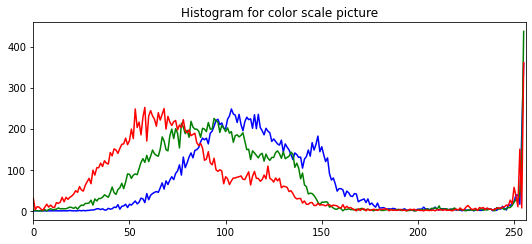

In [70]:
rgb_density_histogram('../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_01_01.jpg')

In [71]:
def greeness_over_time(images):
    """
    This function will calculate the greeness overtime and return the array
    that contains the greeness for each image
    
    Params:
        images: the array of image names that we want to get the img from 
    """
    
    #change this to faslse if you don't want to display the image with 
    #green mask
    display_image = True
    
    greeness = []
    
    for img_name in images:
        img = Image.open(img_name).convert('RGB')
        img_arr = np.asarray(img)
        greeness.append(calculate_green_density(img_arr, display_image))
    return greeness

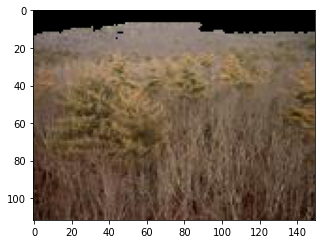

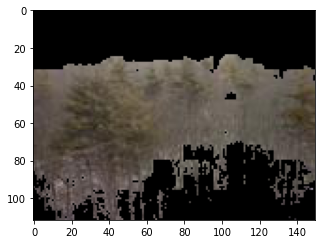

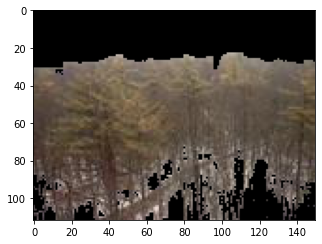

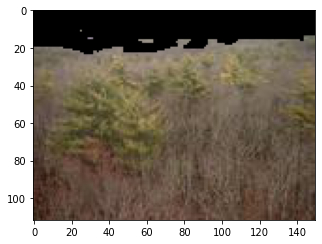

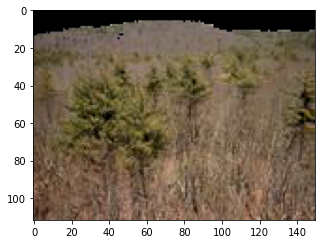

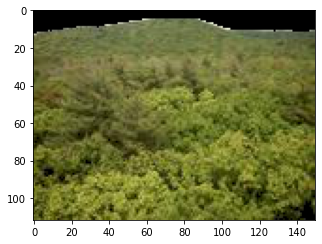

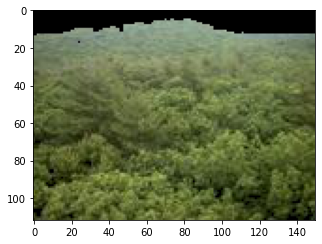

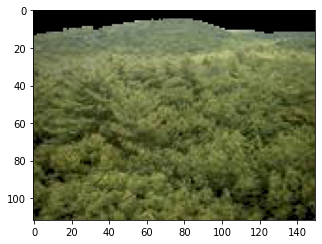

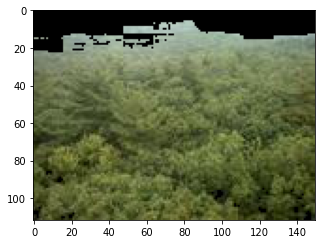

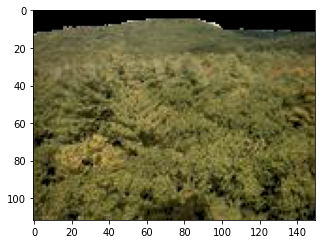

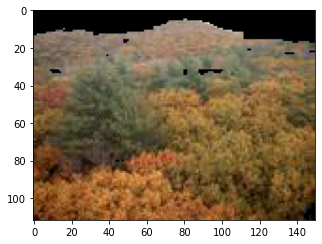

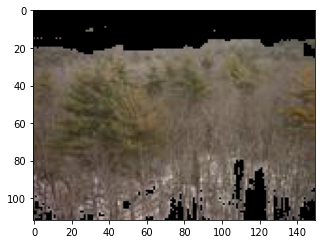

[0.9075,
 0.5579761904761905,
 0.677202380952381,
 0.82875,
 0.9130952380952381,
 0.9154166666666667,
 0.9021428571428571,
 0.9075595238095238,
 0.869702380952381,
 0.9103571428571429,
 0.8868452380952381,
 0.7853571428571429]

In [72]:
greeness_over_time(lastYearImg)

# Making white mask

In [73]:
def applyWhiteMask(image, show_img = False):
    """
    this fucntion will apply white mask to the the image and return
    the mask, it will show the image with white mask applied if specified
    
    Params: image: the image object that we want to apply
            show_img: whether or not we want to display the image with mask apply
    """
    hsv = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, (0,0,168), (172,111,255))
    #res = cv2.bitwise_and(image,image, mask= mask)
    white = np.zeros_like(image, np.uint8)
    imask = mask > 0
    white[imask] = image[imask]
    ####display image
    if show_img:
        plt.imshow(white)
        plt.show()
    return mask
    

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_01_01.jpg


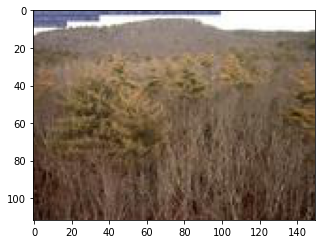

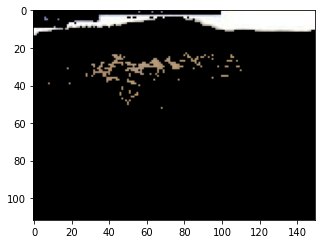

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_02_01.jpg


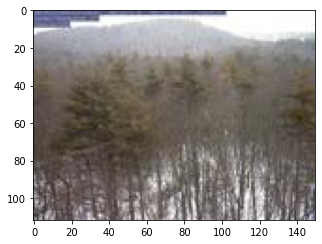

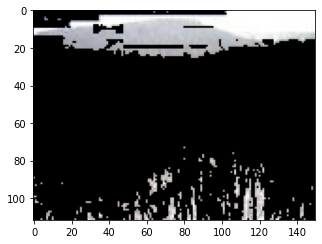

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_03_01.jpg


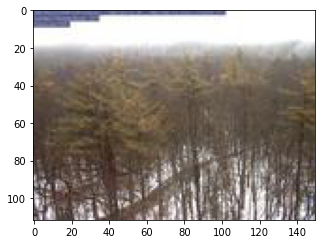

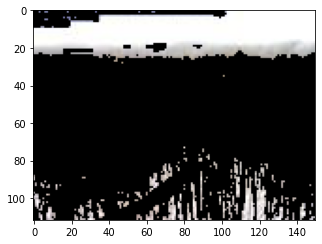

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_04_01.jpg


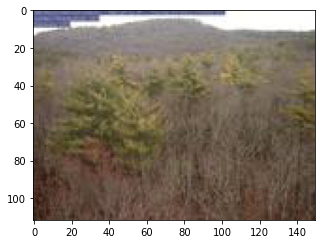

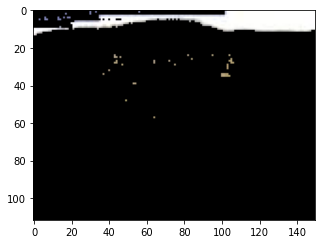

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_05_01.jpg


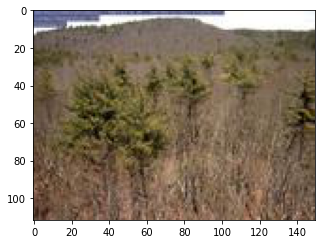

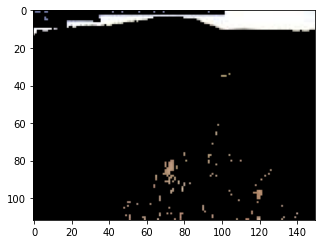

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_06_01.jpg


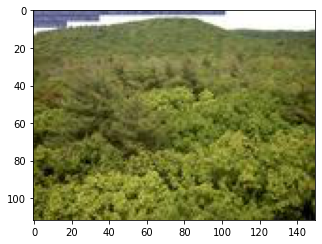

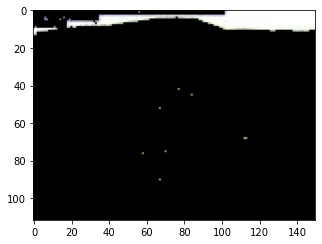

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_07_01.jpg


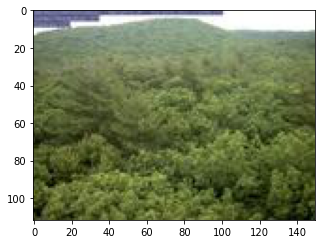

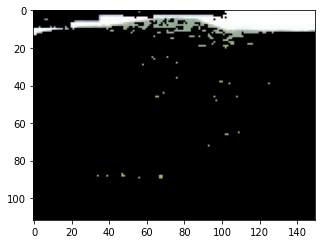

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_08_01.jpg


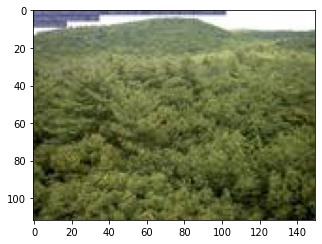

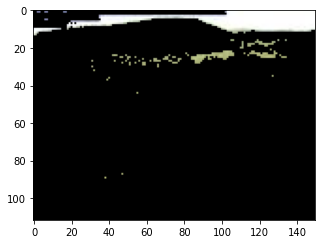

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_09_01.jpg


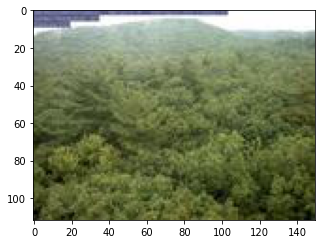

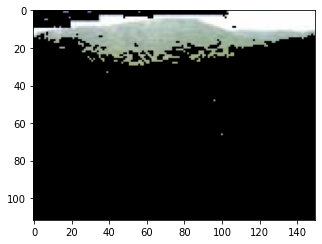

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_10_01.jpg


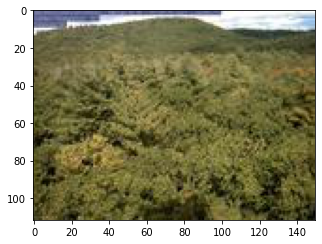

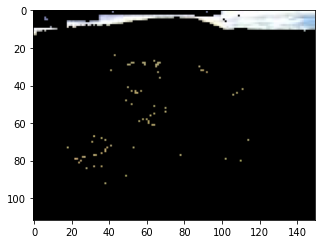

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_11_01.jpg


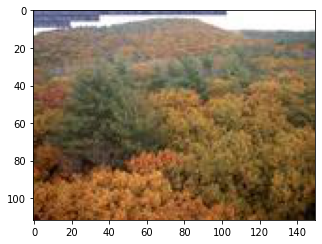

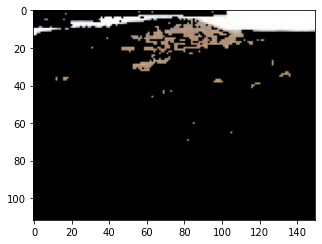

../data_raw/HARV/NEON.D01.HARV.DP1.00033_2021_12_01.jpg


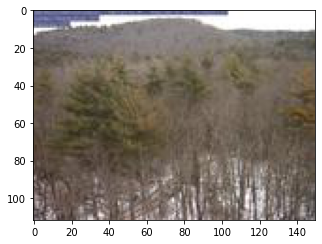

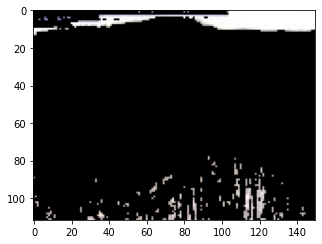

In [74]:
for img_name in lastYearImg:
    img = Image.open(img_name).convert('RGB')
    print(img_name)
    # display the original image
    plt.imshow(img)
    plt.show()
    # display the image with the white mask applied
    applyWhiteMask(np.asarray(img), True)
    